# Naive Bayes

Applied to Youtube Comments for Spam Classification

In [ ]:
#Algorithm 2 - Naive Bayes

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import math
from operator import mul
from IPython.display import Image
import PIL
import random
import seaborn as sns

#Scikit.learn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from nltk.stem.lancaster import LancasterStemmer


#NLTK Packages
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import words, stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.api import StemmerI

nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shaun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Importing the dataset by combining CSV files
comment_data = []
files = ['Youtube01-Psy.csv', 'Youtube02-KatyPerry.csv', 'Youtube03-LMFAO.csv', 'Youtube04-Eminem.csv', 'Youtube05-Shakira.csv']
for file in files:
    file_data = pd.read_csv(file)
    comment_data.append(file_data)
comment_data = pd.concat(comment_data)

#Looking at data
comment_data.info()
comment_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1711 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [ ]:
#Counting numbers of positives and negatives
comment_data['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

This shows an even distribution of spam and "ham"(not ham)

In [ ]:
#Removing extra features
def remove_excess_features (features, dataset):
    dataset.drop(features, axis=1, inplace=True)

#Assuming we do not need Author, Commend_Id, and date?
remove_excess_features(['AUTHOR', 'COMMENT_ID', 'DATE'], comment_data)

comment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
CONTENT    1956 non-null object
CLASS      1956 non-null int64
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


# Text Cleanup
Here we will a) remove all non printable characters b) tokenize the phrases into words c) remove stopwords

In [ ]:
#Removing all non-printable characters
printable = set(string.printable)
comment_data['CLEANED_CONTENT'] = comment_data['CONTENT'].apply(lambda x: ''.join([" " if i not in printable else i for i in x]))

#Apply Tokenization
import re
def wordize_column(comment):
    return " ".join(re.findall("[A-Za-z]+",comment.lower()))
comment_data["WORDIZED_CONTENT"] = comment_data['CLEANED_CONTENT'].apply(wordize_column)

#Remove used content columns
final_comment_data = comment_data.drop(["CONTENT", "CLEANED_CONTENT"], axis=1)

#Removing stopwords
def remove_stopwords(comment):
    commentwords = word_tokenize(comment)
    resultwords = [word for word in commentwords if not word in stop_words]
    result = ' '.join(resultwords)
    return result

#Iterate over dataframe
final_comment_data["NO_STOP_CONTENT"] = final_comment_data["WORDIZED_CONTENT"].map(remove_stopwords)
df = final_comment_data.drop(["WORDIZED_CONTENT"],axis=1)

df.head(n=20)

,CLASS,NO_STOP_CONTENT
0,1,huh anyway check tube channel kobyoshi
1,1,hey guys check new channel first vid us monkey...
2,1,test say murdev com
3,1,shaking sexy ass channel enjoy
4,1,watch v vtarggvgtwq check
5,1,hey check new website site kids stuff kidsmedi...
6,1,subscribe channel
7,0,turned mute soon came wanted check views
8,1,check channel funny videos
9,1,u check channel tell next


# Stemming

Porter Stemmer is the least aggressive stemming algorithm. Snowball Stemmer or Porter II is slightly more aggressive, whilst retaining semantic value in the words. The Lancaster stemmer is the most aggressive, sometimes removing the majority of the original word. The fourth option is not to apply stemming at all, and compare all 4 methods.

In [ ]:
#Stemming content column

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

#Using Porter Stemmer -- Option A
# stemmer = PorterStemmer()

#Using Snowball Stemmer -- Option B
# stemmer = SnowballStemmer("english")

#using Lancaster Stemmer -- Option C
# stemmer = LancasterStemmer()

#using no Stemmer -- Option D
def stem_sentences(sentence):
    return sentence

df['STEMMED_CONTENT'] = df['NO_STOP_CONTENT'].apply(stem_sentences)
df = df.drop(['NO_STOP_CONTENT'],axis=1)

df.head(n=20)

,CLASS,STEMMED_CONTENT
0,1,huh anyway check tube channel kobyoshi
1,1,hey guys check new channel first vid us monkey...
2,1,test say murdev com
3,1,shaking sexy ass channel enjoy
4,1,watch v vtarggvgtwq check
5,1,hey check new website site kids stuff kidsmedi...
6,1,subscribe channel
7,0,turned mute soon came wanted check views
8,1,check channel funny videos
9,1,u check channel tell next


Next we apply count vectorizer and TFIDF transformer (combined under TfidfVectorizer) to the dataset. This will convert a collection of raw documents to a matrix of TF-IDF features. We also have the option to apply ngram range. We will keep unigrams to start with.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['STEMMED_CONTENT'])
y = df['CLASS']

# print(tfidf.get_feature_names())
X.shape

(1956, 4101)

## PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])

N = 2 #number of components used for PCA
TF_IDF_matrix = X.T

terms_rep = np.dot(U[:,:N], np.diag(s[:N]))
docs_rep = np.dot(np.diag(s[:N]), VT[:N, :]).T # N x N matrix 
U, s, VT = np.linalg.svd(TF_IDF_matrix.toarray()) 
X_PCA = np.dot(U[:,:N], np.dot(np.diag(s[:N]), VT[:N, :]))
X_PCA = X_PCA.T

# X_PCA

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(docs_rep[:,0], docs_rep[:,1],c=y, cmap=cmap)
plt.title("Document Representation")
plt.show()
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(terms_rep[:,0], terms_rep[:,1], cmap=cmap)
plt.title("Term Representation")
plt.show()

## Visualizing the vocabulary related to spam, and that related to ham.

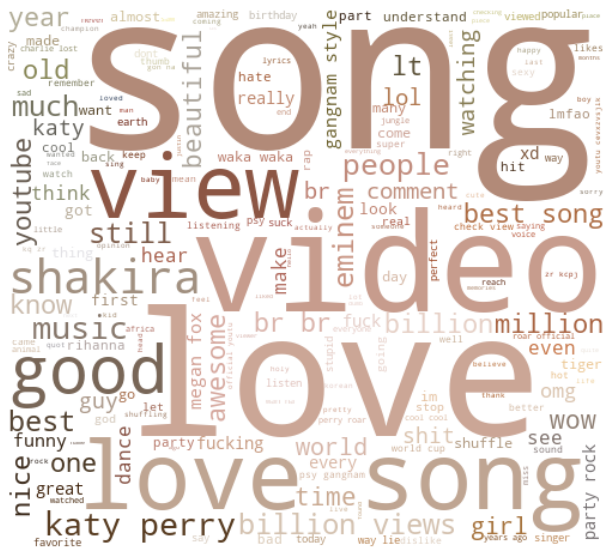

In [ ]:
#Visualising "spam" vs "not spam" vocabulary
from wordcloud import WordCloud, ImageColorGenerator

#Ham
ham = df[df['CLASS'] == 0]
ham_string = []
for t in ham.STEMMED_CONTENT:
    ham_string.append(t)
ham_string = pd.Series(ham_string).str.cat(sep=' ')    

#Wordcloud for not spam comments
mask = np.array(PIL.Image.open('img/ham.jpg'))
wordcloud_ham = WordCloud(width=1600, height=800,max_font_size=200, background_color="white", mode="RGBA", mask=mask).generate(ham_string)

#Create colouring from image
image_colours = ImageColorGenerator(mask)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_ham.recolor(color_func=image_colours), interpolation="bilinear")
plt.axis("off")
plt.show()

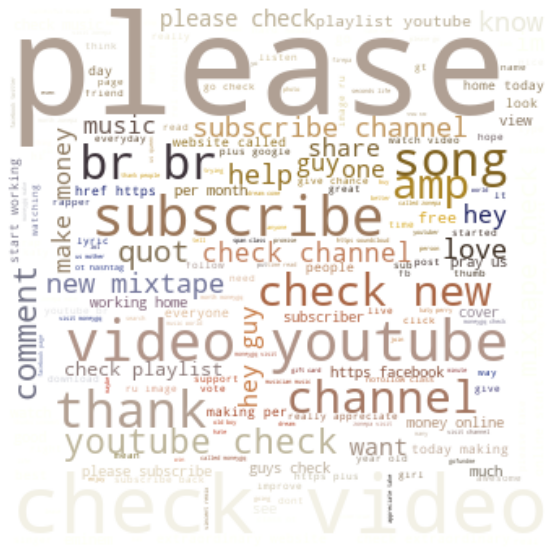

In [ ]:
from wordcloud import WordCloud

#Spam
spam = df[df['CLASS'] == 1]
spam_string = []
for t in spam.STEMMED_CONTENT:
    spam_string.append(t)
spam_string = pd.Series(spam_string).str.cat(sep=' ')    

#Wordcloud for not spam comments
mask = np.array(PIL.Image.open('img/spam.jpg'))
wordcloud_spam = WordCloud(width=1600, height=800,max_font_size=200, background_color="white", mode="RGBA", mask=mask).generate(spam_string)

#Create colouring from image
image_colours = ImageColorGenerator(mask)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_spam.recolor(color_func=image_colours), interpolation="bilinear")
plt.axis("off")
plt.show()

# Using Sklearn to apply Naive Bayes

First the package-optimized method will be applied to the data.

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Fitting Multinomial Naive Bayes to Training Set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha = 1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

'''Plotting a confusion matrix as follows:
[True negative, False Positive
 False Negative, True Positive]'''

#Building the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[167,  16],
       [ 15, 194]], dtype=int64)

----------------------------------------------------------------------
Naive Bayes Accuracy(Sklearn): 0.9209183673469388
----------------------------------------------------------------------
Naive Bayes F1(Sklearn): 0.9260143198090691
----------------------------------------------------------------------
Naive Bayes Precision(Sklearn): 0.9238095238095239
----------------------------------------------------------------------
Naive Bayes Recall(Sklearn): 0.9282296650717703
----------------------------------------------------------------------


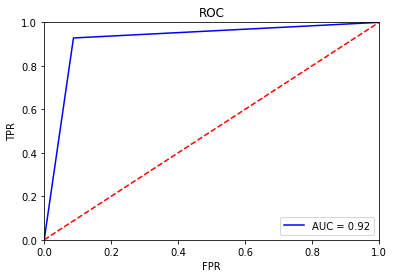

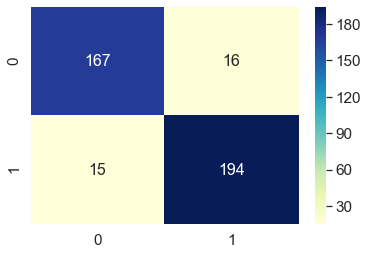

In [ ]:
#Gauging performance using Sklearn metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

print("----------------------------------------------------------------------")
print("Naive Bayes Accuracy(Sklearn):",accuracy_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Naive Bayes F1(Sklearn):",f1_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Naive Bayes Precision(Sklearn):",precision_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Naive Bayes Recall(Sklearn):",recall_score(y_test, y_pred))
print("----------------------------------------------------------------------")


fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d",  cmap="YlGnBu") # font size

# Building Naive Bayes from scratch

Our own model will be built at this point, looking at effectiveness of both negative and positive values

In [ ]:
#Splitting dataframe into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 0)

#splitting train dataframe into spam and ham
ham_df = train.loc[train['CLASS'] == 0].reset_index(drop = True)
spam_df = train.loc[train['CLASS'] == 1].reset_index(drop = True)

#splitting test dataframe into spam and ham
ham_df_test = test.loc[test['CLASS'] == 0].reset_index(drop = True)
spam_df_test = test.loc[test['CLASS'] == 1].reset_index(drop = True)

Building dictionary of counts for words according to whether the word is incident in a row with class is spam, or ham.
First all the words are combined into a string.

In [ ]:
ham_string = []
spam_string = []
for t in ham_df.STEMMED_CONTENT:
    ham_string.append(t)
ham_string = pd.Series(ham_string).str.cat(sep=' ')

for t in spam_df.STEMMED_CONTENT:
    spam_string.append(t)
spam_string = pd.Series(spam_string).str.cat(sep=' ')

print("Ham corpus head")
print(ham_string[0:1000])
print("--------------------------------------------------------------------------")
print("Spam corpus head")
print(spam_string[0:1000])

Ham corpus head
blue eyes trusted uranus bless america going voyage first comment tell family loved best song eva loves likeee little kidz like billon people earth millon get facts straight posting comments still watching years later love songs eminem rap god like anyone else think video theme bit insult days later super rihanna population world billion really hardcore wow song ever reach billion views katy conqueror haki gt best party song literally party rock housee tonight wowwwwwwwwwwwwwwwwwwwwwwwwwwwwww awesome best song ever believe soccer promotes terrorism bad choice shakira great mother jungle sweet natural like videos came check views goodbye want see shakira football amazing song tiger succumbs beautiful girl probably male tiger ha ha ha like love much people friends love shakira song never get old lt katy voice angel telephone ching ching ling long ding ring yaaaaaa ganga sty fuck many comments remeber good ol days songs butts fire amazing song remember torunament like toda

In [ ]:
def word_counter(string):
    my_string = string.lower().split()
    this_dict = {}
    for word in my_string:
        if word in this_dict:
            this_dict[word] += 1
        else:
            this_dict[word] = 1
    return(this_dict)

ham_dict = word_counter(ham_string)
spam_dict = word_counter(spam_string)

print(len(ham_dict))
print(len(spam_dict))

1211
2814


It was decided to build a classifier of type class for this method.

![Naive-Bayes Formula](https://uc-r.github.io/public/images/analytics/naive_bayes/naive_bayes_icon.png)

Figure 1 - Naive Bayes Formula



![Naive-Bayes Formula](https://miro.medium.com/max/372/1*uWrDuiINGyU4iYCLf81stw.png)

Figure 2 - Probability for feature per class

In [ ]:
class NB_classifier:
    
#     constructor to initialise the Naive Bayes class
    def __init__(self, spam, ham, spam_dict, ham_dict):
        self.spam_count = spam.shape[0]
        self.ham_count = ham.shape[0]
        self.doc_count = self.spam_count + self.ham_count
        self.spam = spam_dict
        self.ham = ham_dict
    
    #Training Model - based on the Naive Bayes function in Figure 1
    def train(self):
        self.features = {}
        self.features['spamFeatures'] = {}
        self.features['hamFeatures'] = {}
        
        #Gathering a priori probabilities by class
        self.priorLogSpam = np.log10(self.spam_count/self.doc_count)
        self.priorLogHam = np.log10(self.ham_count/self.doc_count)
        
        #Calculate probability for feature per class
        #Instead of adding 1, we added the Vocabulary for smoothing in the denominator as in Figure 2
        for word, count in self.spam.items():
            self.features['spamFeatures'][word] = np.log10((count + 1)/(self.spam_count + self.doc_count))
       
        for word, count in self.ham.items():
            self.features['hamFeatures'][word] = np.log10((count + 1)/(self.ham_count + self.doc_count))
 
   #Testing the model
    def test(self, row):
        row = [x for x in row.split(" ")]
        spam_val = self.priorLogSpam
        ham_val = self.priorLogHam
    
#         Smoothed probabilities are calculated below, these are useful when the the word in the comment is not found
#         but is found in another class(in this case if it's found in the ham vocabulary/dictionary)
        smooth_spam = np.log10(1/(self.spam_count + self.doc_count))
        smooth_ham = np.log10(1/(self.ham_count + self.doc_count))

#         for every word found self.features
#         if that word is spam then it is added to spam_val, otherwise it is added to ham_val
        for feature in self.features:
            if feature == 'spamFeatures':
                for word in row:
                    if word in self.features['spamFeatures']:
                        spam_val += self.features['spamFeatures'][word]
                    elif word in self.features['hamFeatures']:
                        spam_val += smooth_spam
            elif feature == 'hamFeatures':
                for word in row:
                    if word in self.features['hamFeatures']:
                        ham_val += self.features['hamFeatures'][word]
                    elif word in self.features['spamFeatures']:
                        ham_val += smooth_ham
                        
#         a final check is done to decide the overall score of the comment, depending on its value it's assigned as spam or ham
        if spam_val > ham_val:
            return ('spam', spam_val)
        elif ham_val > spam_val:
            return ('ham', ham_val)
        else:
            return ('ham', ham_val)

#     the evaluation method will be performed on all the rows of the dataset
#     we pass the instance of the class Naive Bayes and 2 empty arrays which will hold the spam and ham rows
    def evaluation(obj,spam_test_rows = [], ham_test_rows = []):
        actual_results = []
        predicted_results = []
        
#         the 1st loop is used to predict,using the test class, whether a comment is spam
        for comment in spam_test_rows:
            outcome = obj.test(comment)
            actual_results.append(0)
            predicted_results.append(0 if outcome[0] == 'spam' else 1)
            
#         the 2nd loop is used to predict, using the test class, whether a comment is ham
        for comment in ham_test_rows:
            outcome = obj.test(comment)
            actual_results.append(1)
            predicted_results.append(1 if outcome[0] == 'ham' else 0)
        '''Plotting a confusion matrix as follows:
        [True negative, False Positive
         False Negative, True Positive]'''
        
        # Finally using the results obtained above, we plot the Confusion Matrix
        cm = confusion_matrix(actual_results, predicted_results)
        print(cm)
        precision = str(round(precision_score(actual_results,predicted_results)*100,2))
        print("Naive Bayes precision:",precision,"%")
        accuracy = str(round(accuracy_score(actual_results, predicted_results)*100,2))
        print("Naive Bayes accuracy:",accuracy,"%")
        f1 = str(round(f1_score(actual_results,predicted_results)*100,2))
        print("Naive Bayes f1_score:",f1,"%")
        recall = str(round(recall_score(actual_results,predicted_results)*100,2))
        print("Naive Bayes recall:",recall,"%")
        
        sns.set(font_scale=1.4) # for label size
        sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d",  cmap="YlGnBu") # font size

        plt.show()

        return(actual_results, predicted_results)

## Building the classifier

[[205   4]
 [ 78 105]]
Naive Bayes precision: 96.33 %
Naive Bayes accuracy: 79.08 %
Naive Bayes f1_score: 71.92 %
Naive Bayes recall: 57.38 %


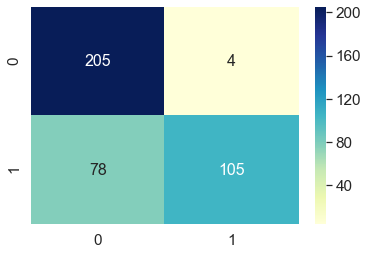

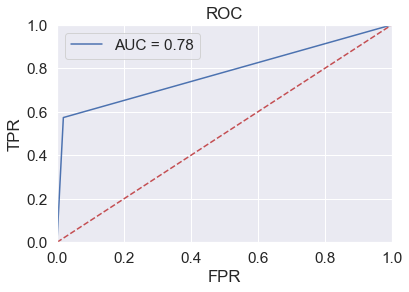

In [ ]:
nb_classifier = NB_classifier(spam = spam_df['STEMMED_CONTENT'], ham = ham_df['STEMMED_CONTENT'],spam_dict = spam_dict, ham_dict = ham_dict)
nb_classifier.train()
actual_results, predicted_results = nb_classifier.evaluation(spam_df_test['STEMMED_CONTENT'], ham_df_test['STEMMED_CONTENT'])

fpr, tpr, threshold = roc_curve(actual_results, predicted_results)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()



## Using K-Fold Cross Validation

In [ ]:
def k_fold_cross_validation(df, folds):
#    Split dataset in k-fold parts
    origdf = df.reset_index(drop = True)
    train_test_split = list()
    foldsize = int(origdf.shape[0]/folds)
    indexes = origdf.index.values.tolist()
    for i in range(folds):
        thisfold = list()
        while len(thisfold) < foldsize:
            index = random.sample(indexes,1)
            thisfold.append(index[0])
            indexes.remove(index[0])      
        train_test_split.append(thisfold)
        
    return train_test_split

In [ ]:
def optimise_model(original_df, folds):
#    First there is the random split using the k-fold cross validation
    k_fold_split = k_fold_cross_validation(original_df, folds)
    training_fold = pd.DataFrame()
    testing_fold = pd.DataFrame()
    for i in range(0,len(k_fold_split)):
        
        
        all_k_fold_split = []
        k_fold_split = k_fold_cross_validation(original_df, folds)
        testing_fold.drop(testing_fold.index, inplace=True)
        training_fold.drop(testing_fold.index, inplace=True)
        print('Results for fold', i+1)
        
#       fold i will be used for testing and the other folds will be used for training
        testing_fold = original_df.iloc[k_fold_split[i]]
        del k_fold_split[i]
        
        for j in range(len(k_fold_split)):
            all_k_fold_split += k_fold_split[j]
            
        training_fold = original_df.iloc[all_k_fold_split] 
               
        #splitting train dataframe into spam and ham
        ham_df = training_fold.loc[training_fold['CLASS'] == 0].reset_index(drop = True)
        spam_df = training_fold.loc[training_fold['CLASS'] == 1].reset_index(drop = True)
        
#        #splitting test dataframe into spam and ham
        ham_df_test = testing_fold.loc[testing_fold['CLASS'] == 0].reset_index(drop = True)
        spam_df_test = testing_fold.loc[testing_fold['CLASS'] == 1].reset_index(drop = True )
        
        ham_string = []
        spam_string = []
        for t in ham_df.STEMMED_CONTENT:
            ham_string.append(t)
        ham_string = pd.Series(ham_string).str.cat(sep=' ')
        
        for t in spam_df.STEMMED_CONTENT:
            spam_string.append(t)
        spam_string = pd.Series(spam_string).str.cat(sep=' ')
    
        
        ham_dict = word_counter(ham_string)
        spam_dict = word_counter(spam_string)
        
        nb_classifier = NB_classifier(spam = spam_df['STEMMED_CONTENT'], ham = ham_df['STEMMED_CONTENT'],spam_dict = spam_dict, ham_dict = ham_dict)
        nb_classifier.train()
        actual_results, predicted_results = nb_classifier.evaluation(spam_df_test['STEMMED_CONTENT'], ham_df_test['STEMMED_CONTENT'])
        
        fpr, tpr, threshold = roc_curve(actual_results, predicted_results)
        roc_auc = auc(fpr, tpr)

        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'best')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
        plt.show()

        
    return testing_fold, training_fold

## Results obtained after k-folds

Results for fold 1
[[249   2]
 [ 93 145]]
Naive Bayes precision: 98.64 %
Naive Bayes accuracy: 80.57 %
Naive Bayes f1_score: 75.32 %
Naive Bayes recall: 60.92 %


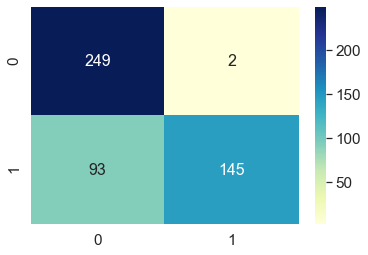

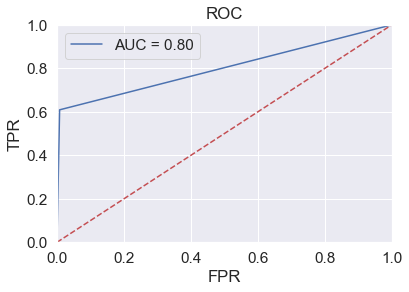

Results for fold 2
[[256   1]
 [ 90 142]]
Naive Bayes precision: 99.3 %
Naive Bayes accuracy: 81.39 %
Naive Bayes f1_score: 75.73 %
Naive Bayes recall: 61.21 %


C:\Users\Dylan Schembri\Anaconda3\envs\CIS5110\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


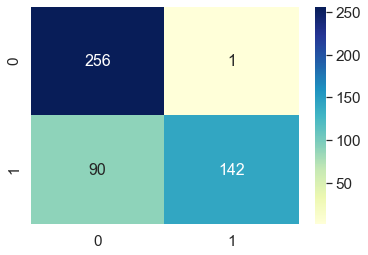

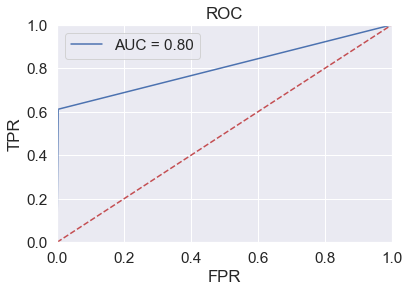

Results for fold 3
[[259   2]
 [ 84 144]]
Naive Bayes precision: 98.63 %
Naive Bayes accuracy: 82.41 %
Naive Bayes f1_score: 77.01 %
Naive Bayes recall: 63.16 %


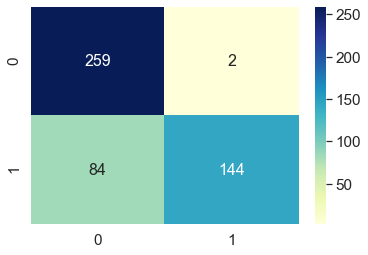

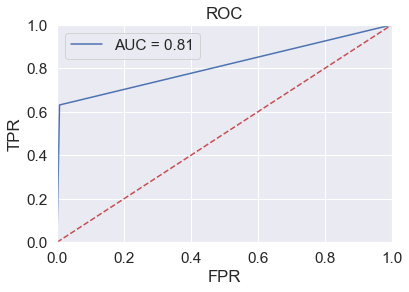

Results for fold 4
[[245   2]
 [100 142]]
Naive Bayes precision: 98.61 %
Naive Bayes accuracy: 79.14 %
Naive Bayes f1_score: 73.58 %
Naive Bayes recall: 58.68 %


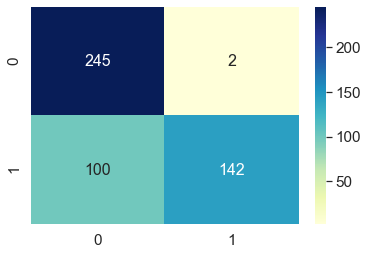

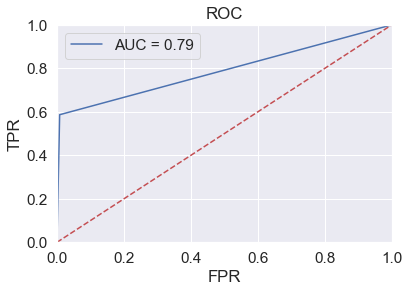

In [ ]:
test, trg = optimise_model(df, 4)